In [ ]:
#git clone or import project

In [ ]:
%cd /content/assignment3-21-robustnet-1/
!pip install -r requirements.txt

/content/assignment3-21-robustnet-1


In [ ]:
#!/usr/bin/env python3 
import os
import argparse
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms

from attacks import *

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

valid_size = 1024 
batch_size = 32 
criterion = nn.NLLLoss()
'''Basic neural network architecture (from pytorch doc).'''
class Net(nn.Module):

    model_file="models/default_model.pth"
    '''This file will be loaded to test your model. Use --model-file to load/store a different model.'''
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    

    

    def save(self, model_file):
        '''Helper function, use it to save the model weights after training.'''
        torch.save(self.state_dict(), model_file)

    def load(self, model_file):
        self.load_state_dict(torch.load(model_file, map_location=torch.device(device)))

        
    def load_for_testing(self, project_dir='./'):
        '''This function will be called automatically before testing your
           project, and will load the model weights from the file
           specify in Net.model_file.
           
           You must not change the prototype of this function. You may
           add extra code in its body if you feel it is necessary, but
           beware that paths of files used in this function should be
           refered relative to the root of your project directory.
        '''        
        self.load(os.path.join(project_dir, Net.model_file))



def train_model(net, train_loader, pth_filename, num_epochs):
    '''Basic training function (TODO)'''
    print("Starting training")
    
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    train_loss = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        loss_per_epoch = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_per_epoch+=loss.item()
            loss.backward()
            optimizer.step()

        epoch_loss = loss_per_epoch/len(train_loader)
        train_loss.append(epoch_loss)
        print(f'epoch : {epoch} --- loss : {epoch_loss} ')

    net.save(pth_filename)
    print('Model saved in {}'.format(pth_filename))
    return train_loss


####### Testing ############
def test_natural(net, test_loader):
    '''Basic testing function.'''

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i,data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total
    
######################## Attack Testing ########################
def test_fgsm(net,test_loader,epsilon):
  correct = 0
  for i,data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            images.requires_grad = True
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, nat_pred = torch.max(outputs.data, 1)
            if nat_pred.item() != labels.item():
              continue
            #if test sample is correctly predicted
            loss = criterion(outputs, labels)
            net.zero_grad()
            loss.backward()

            data_grad = images.grad.data
            adv_data = fgsm(images,epsilon,data_grad)
            output = net(adv_data)
            _,adv_pred = torch.max(output.data, 1)
            if adv_pred.item() == labels.item():
              correct+=1
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return 100*final_acc


def test_pgd(net, test_loader, eta, eps, steps):
    correct = 0
    for i, data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)
        adv_data = images.clone().detach().to(device)
        for _ in range(steps):
            # calculate outputs by running images through the network
            adv_data.requires_grad = True
            outputs = net(adv_data)

            _, nat_pred = torch.max(outputs.data, 1)
            if nat_pred.item() != labels.item():
                break
            loss = criterion(outputs, labels)
            net.zero_grad()
            loss.backward()

            data_grad = adv_data.grad.data
            adv_data = pgd(adv_data, images, eta, eps, data_grad)
        output = net(adv_data)
        _, adv_pred = torch.max(output.data, 1)
        if adv_pred.item() == labels.item():
            correct += 1
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_loader), final_acc))
    return 100 * final_acc


##########################################

def get_train_loader(dataset, valid_size=1024, batch_size=32):
    '''Split dataset into [train:valid] and return a DataLoader for the training part.'''

    indices = list(range(len(dataset)))
    train_sampler = torch.utils.data.SubsetRandomSampler(indices[valid_size:])
    train = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)

    return train

def get_validation_loader(dataset, valid_size=1024, batch_size=32):
    '''Split dataset into [train:valid] and return a DataLoader for the validation part.'''

    indices = list(range(len(dataset)))
    valid_sampler = torch.utils.data.SubsetRandomSampler(indices[:valid_size])
    valid = torch.utils.data.DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size)

    return valid
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
#Natural accuracy of the natural model (Without defense)
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/basic_model.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Model natural accuracy (valid): 61.81640625


# Images after attacks


In [ ]:
classdict = {
  0:"airplane",
  1: "automobile",
  2: "bird",
  3: "cat",
  4: "deer",
  5: "dog",
  6: "frog",
  7: "horse",
  8: "ship",
  9: "truck"
}
print(classdict[1])

automobile


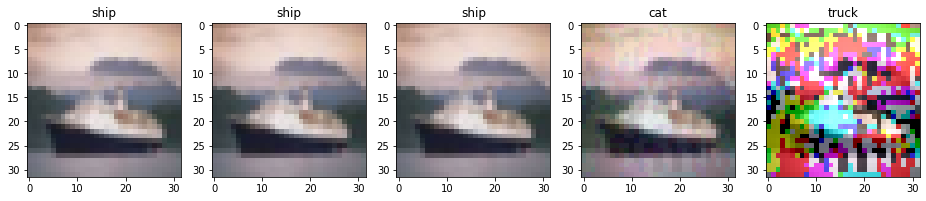

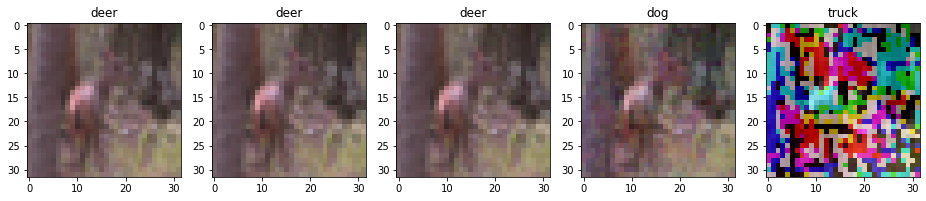

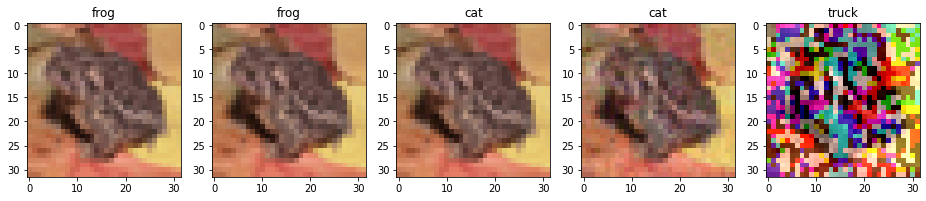

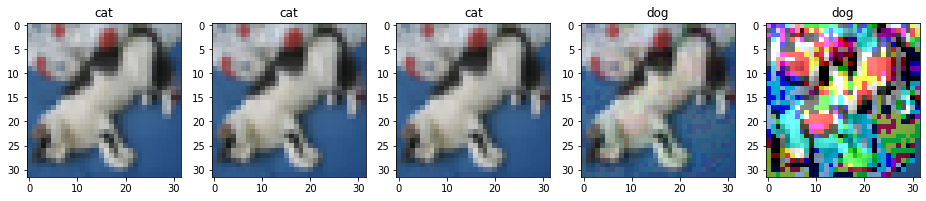

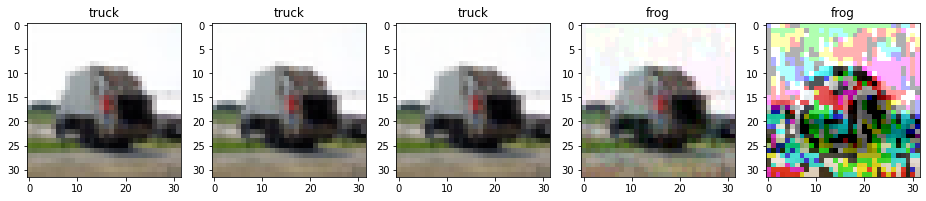

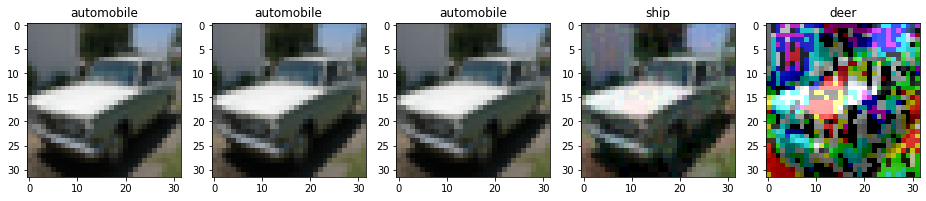

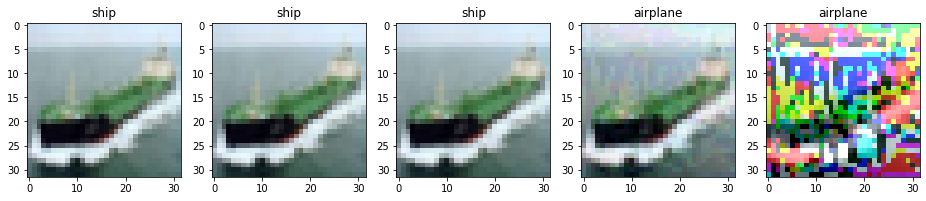

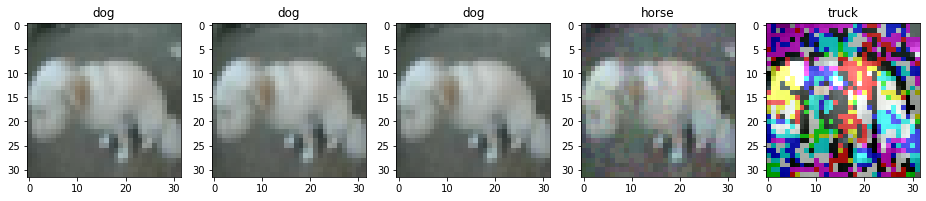

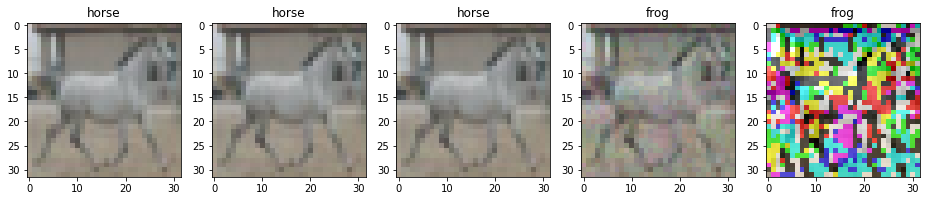

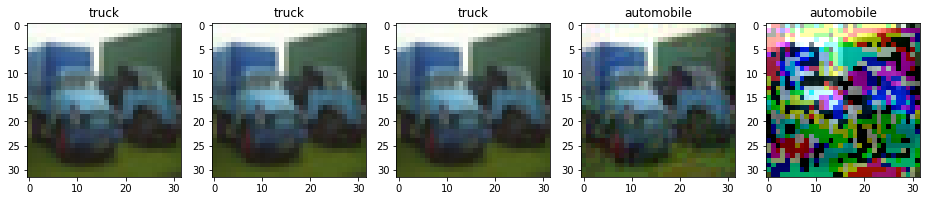

In [90]:
#Images before and after FGSM Attack with eps=[0.0003,0.003,0.03,0.3]
import matplotlib.pyplot as plt
affich=0

for i, data in enumerate(valid_loader, 0):
    images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
    images.requires_grad = True
    outputs = net(images)
        # the class with the highest energy is what we choose as prediction
    _, nat_pred = torch.max(outputs.data, 1)
    if nat_pred.item() != labels.item():
        continue
    # if test sample is correctly predicted
    loss = criterion(outputs, labels)
    net.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    all_images=[images,fgsm(images, 0.0003, data_grad),fgsm(images, 0.003, data_grad),fgsm(images, 0.03, data_grad),fgsm(images, 0.3, data_grad)]

    output1 = net(all_images[1])
    output2 = net(all_images[2])
    output3 = net(all_images[3])
    output4 = net(all_images[4])

    _, labels_pred1 = torch.max(output1.data, 1)
    _, labels_pred2 = torch.max(output2.data, 1)
    _, labels_pred3 = torch.max(output3.data, 1)
    _, labels_pred4 = torch.max(output4.data, 1)

    labels_pred=[labels.item(),labels_pred1.item(),labels_pred2.item(),labels_pred3.item(),labels_pred4.item()]
    if affich<10:
      fig = plt.figure(figsize=(16, 16))
      columns = 5
      rows = 1
      for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(np.transpose(all_images[i-1][0].detach().numpy(), (1, 2, 0)))
        plt.title(classdict[labels_pred[i-1]])
      plt.show()
      affich=affich+1

#print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(0.03, correct, len(valid_loader), final_acc))
#print(100 * final_acc)

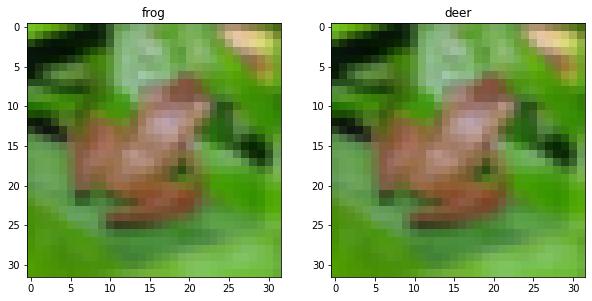

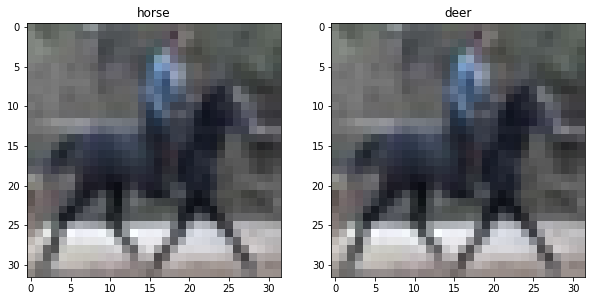

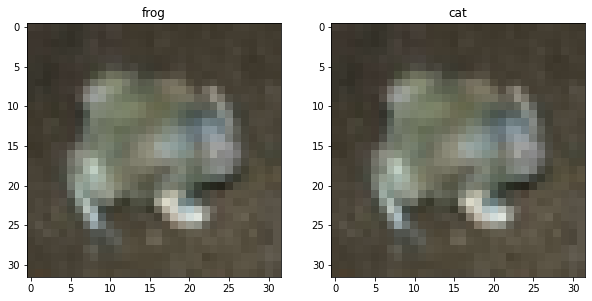

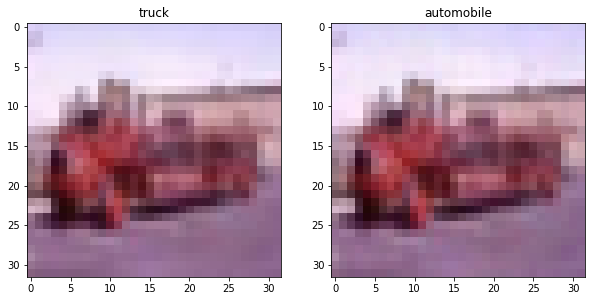

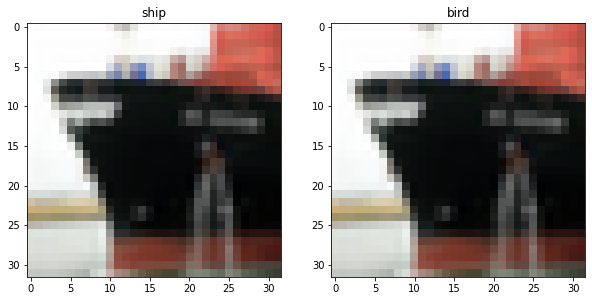

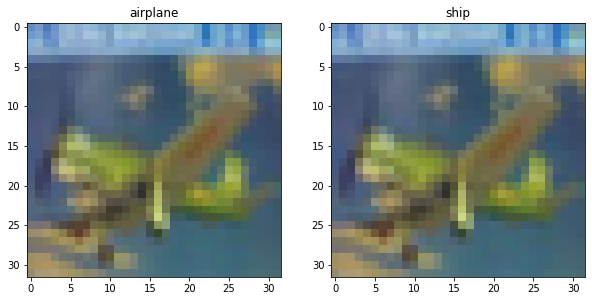

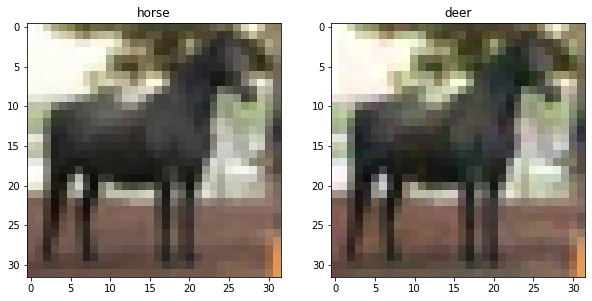

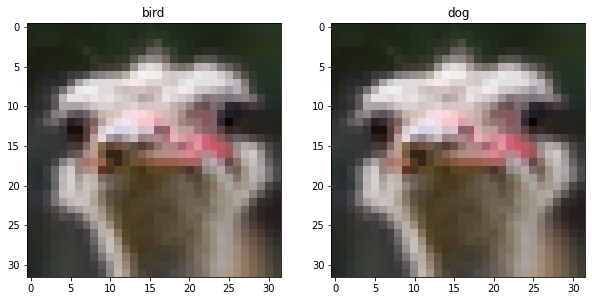

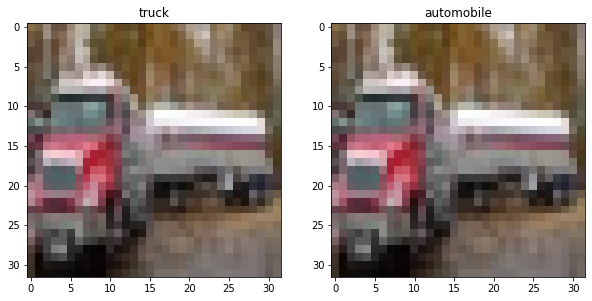

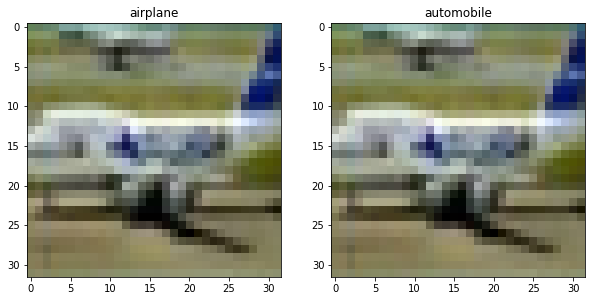

In [96]:
#Images before and after PGD Attack with eps=[0.03]
affich=0
for i, data in enumerate(valid_loader, 0):
  images, labels = data[0].to(device), data[1].to(device)
  adv_data = images.clone().detach().to(device)
  for _ in range(40):
    # calculate outputs by running images through the network
    adv_data.requires_grad = True
    outputs = net(adv_data)

    _, nat_pred = torch.max(outputs.data, 1)
    if nat_pred.item() != labels.item():
        break
    loss = criterion(outputs, labels)
    net.zero_grad()
    loss.backward()

    data_grad = adv_data.grad.data
    adv_data = pgd(adv_data, images, 1 / 255, 0.03, data_grad)
  output = net(adv_data)
  
  _, adv_pred = torch.max(output.data, 1)
  all_images=[images,adv_data]
  all_labels=[labels.item(),adv_pred.item()]
  if affich<10:
    fig = plt.figure(figsize=(10, 10))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(np.transpose(images[0].detach().numpy(), (1, 2, 0)))
    plt.title(classdict[labels.item()])
    fig.add_subplot(rows, columns, 2)
    plt.imshow(np.transpose(adv_data[0].detach().numpy(), (1, 2, 0)))
    plt.title(classdict[adv_pred.item()])
    plt.show()
    affich=affich+1



In [ ]:
def test_pgd(net, test_loader, eta, eps, steps):
    correct = 0
    for i, data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)
        adv_data = images.clone().detach().to(device)
        for _ in range(steps):
            # calculate outputs by running images through the network
            adv_data.requires_grad = True
            outputs = net(adv_data)
            _, nat_pred = torch.max(outputs.data, 1)
            if nat_pred.item() != labels.item():
                break
            loss = criterion(outputs, labels)
            net.zero_grad()
            loss.backward()

            data_grad = adv_data.grad.data
            adv_data = pgd(adv_data, images, eta, eps, data_grad)
        output = net(adv_data)
        _, adv_pred = torch.max(output.data, 1)
        if adv_pred.item() == labels.item():
            correct += 1
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_loader), final_acc))
    return 100 * final_acc


# Accuracies after attacks


In [ ]:
#Plot Accuracy Vs Epsilon FGSM
epsilons = [0, .005, .01, .015, .02, .025, .03,.035,.04,.045,.050,.055,.06,.065,.07,.075,0.08,0.085,0.09,0.095,0.1]
accuracies_fgsm = []
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))


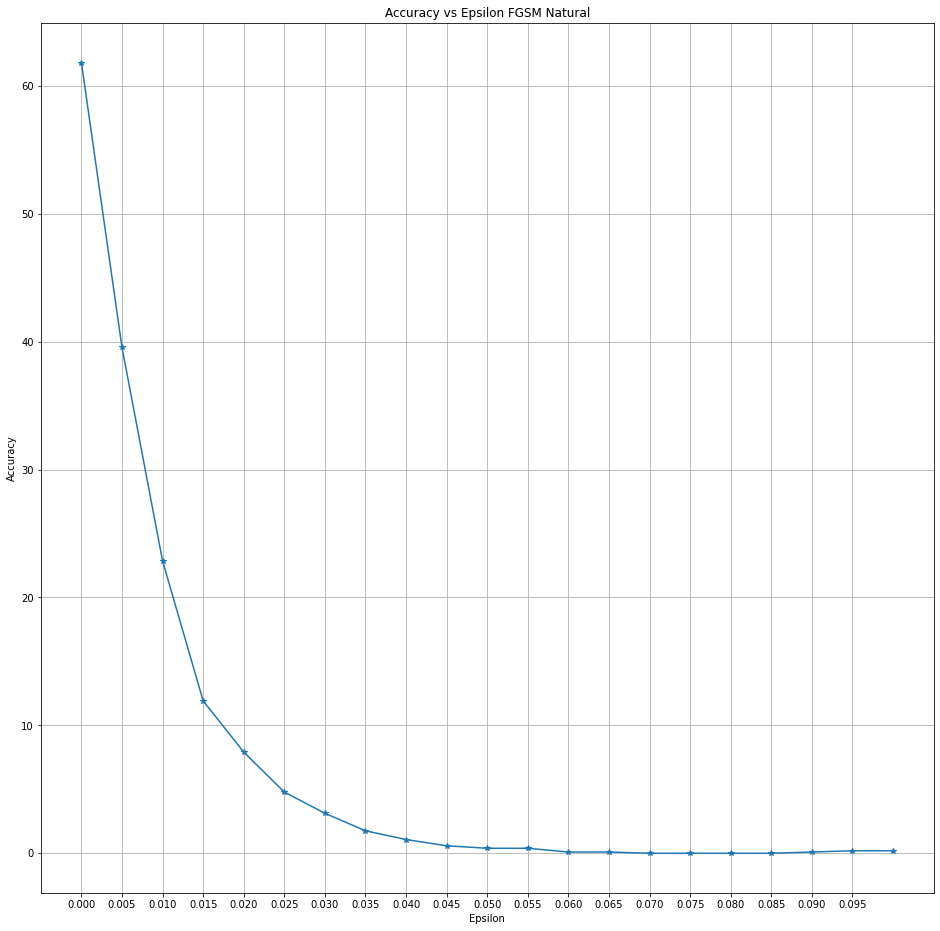

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
plt.plot(epsilons, accuracies_fgsm, "*-")
plt.yticks(np.arange(0, 65, step=10))
plt.xticks(np.arange(0, .1, step=0.005))
plt.title("Accuracy vs Epsilon FGSM Natural")
plt.grid(True)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [82]:
#Plot Accuracy Vs Epsilon PGD
eta = 1 / 255
steps = 40
accuracies_pgd= []
for eps in epsilons:
    acc = test_pgd(net, valid_loader, eta, eps, steps)
    accuracies_pgd.append(acc)
    print("Model pgd attack accuracy (validation): {}".format(acc))

Epsilon: 0	Test Accuracy = 633 / 1024 = 0.6181640625
Model pgd attack accuracy (validation): 61.81640625
Epsilon: 0.005	Test Accuracy = 373 / 1024 = 0.3642578125
Model pgd attack accuracy (validation): 36.42578125
Epsilon: 0.01	Test Accuracy = 154 / 1024 = 0.150390625
Model pgd attack accuracy (validation): 15.0390625
Epsilon: 0.015	Test Accuracy = 60 / 1024 = 0.05859375
Model pgd attack accuracy (validation): 5.859375
Epsilon: 0.02	Test Accuracy = 23 / 1024 = 0.0224609375
Model pgd attack accuracy (validation): 2.24609375
Epsilon: 0.025	Test Accuracy = 4 / 1024 = 0.00390625
Model pgd attack accuracy (validation): 0.390625
Epsilon: 0.03	Test Accuracy = 3 / 1024 = 0.0029296875
Model pgd attack accuracy (validation): 0.29296875
Epsilon: 0.035	Test Accuracy = 0 / 1024 = 0.0
Model pgd attack accuracy (validation): 0.0
Epsilon: 0.04	Test Accuracy = 0 / 1024 = 0.0
Model pgd attack accuracy (validation): 0.0
Epsilon: 0.045	Test Accuracy = 0 / 1024 = 0.0
Model pgd attack accuracy (validation):

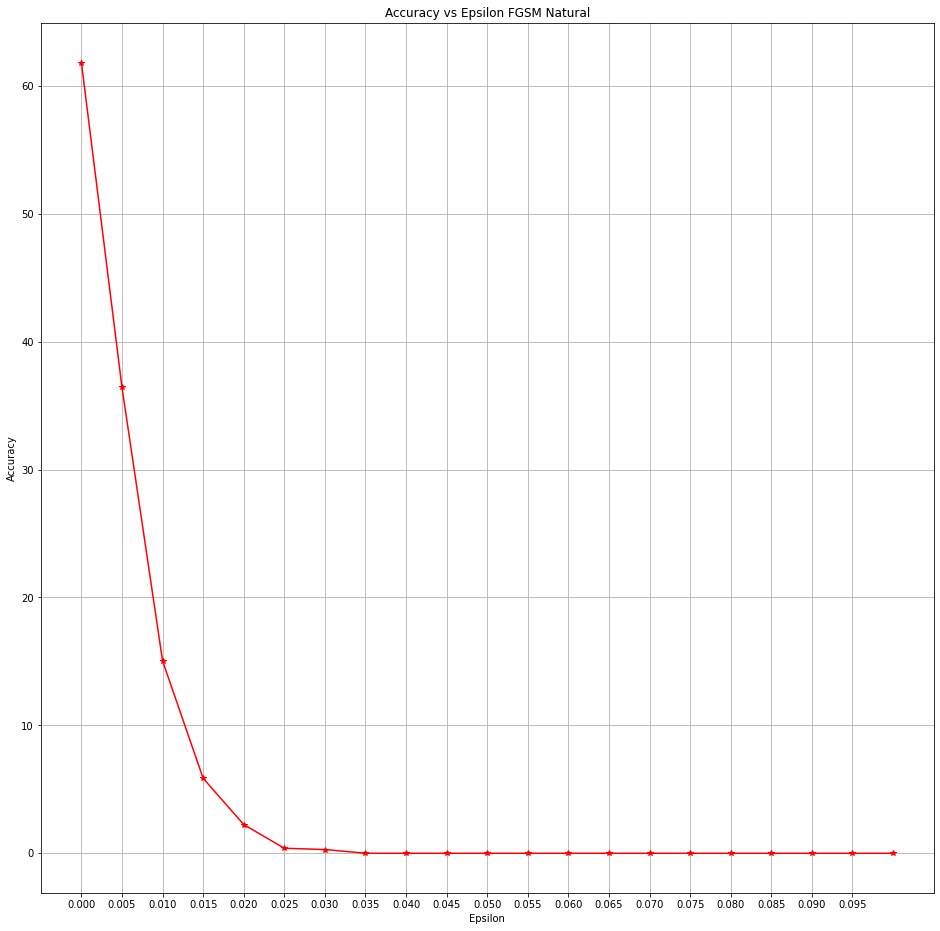

In [71]:
plt.figure(figsize=(16,16))
plt.plot(epsilons, accuracies_pgd, "*-r")
plt.yticks(np.arange(0, 65, step=10))
plt.xticks(np.arange(0, .1, step=0.005))
plt.title("Accuracy vs Epsilon FGSM Natural")
plt.grid(True)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

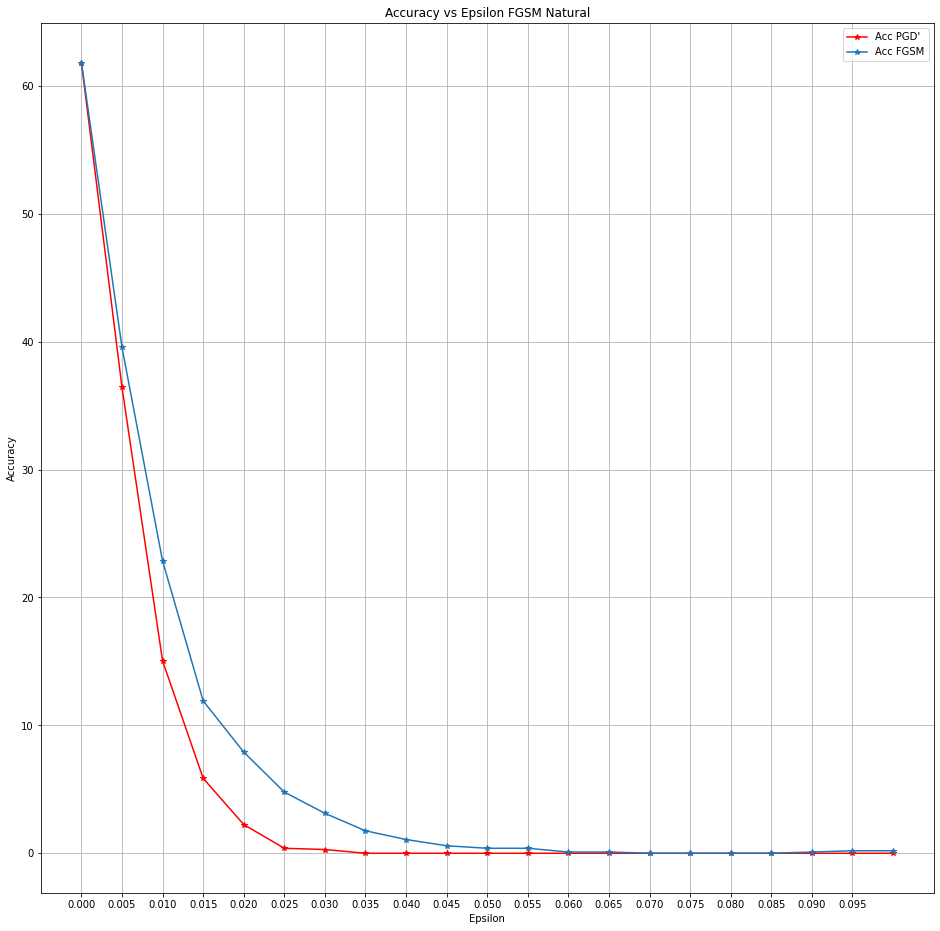

In [77]:
#PGD vs FGSM
plt.figure(figsize=(16,16))
plt.plot(epsilons, accuracies_pgd, "*-r",label="Acc PGD'")
plt.plot(epsilons, accuracies_fgsm, "*-",label="Acc FGSM")
plt.yticks(np.arange(0, 65, step=10))
plt.xticks(np.arange(0, .1, step=0.005))
plt.title("Accuracy vs Epsilon FGSM Natural")
plt.grid(True)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()